<a href="https://colab.research.google.com/github/MuhammadMazid/Twitter-sentiment-analysis-using-LSTM-with-TensorFlow/blob/main/Twitter_sentiment_analysis_using_LSTM_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [ ]:
base_dir = 'C:\\Users\\muham\\Desktop\\'

df = pd.read_csv(base_dir + "twitter.csv")

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.shape


(7613, 5)

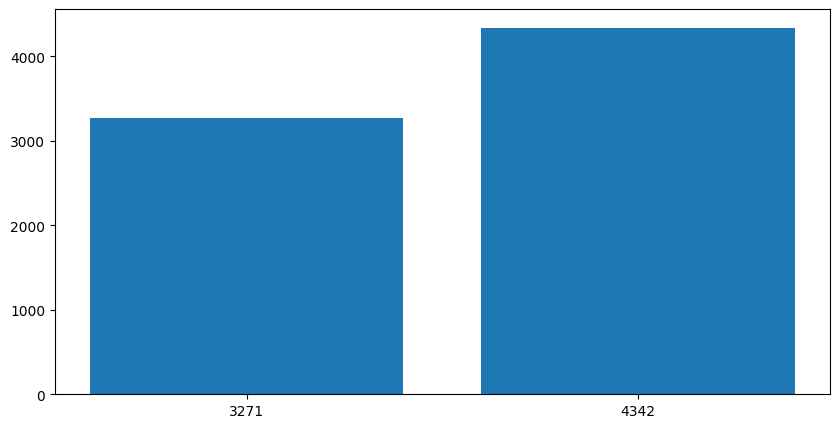

In [ ]:
target_1 = (df.target == 1).sum()
target_0 = (df.target == 0).sum()

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar([str(target_1), str(target_0)],[target_1, target_0])

plt.show()


In [ ]:
# Preprocessing
import re
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
df["text"] = df.text.map(remove_URL)
df["text"] = df.text.map(remove_punct)

In [ ]:
type(df["text"])

pandas.core.series.Series

In [ ]:
# remove stopwords
!pip install nltk




[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ----- ---------------------------------- 0.2/1.5 MB 6.9 MB/s eta 0:00:01
     ---------- ----------------------------- 0.4/1.5 MB 4.9 MB/s eta 0:00:01
     -------------- ------------------------- 0.6/1.5 MB 4.4 MB/s eta 0:00:01
     -------------------- ------------------- 0.8/1.5 MB 4.9 MB/s eta 0:00:01
     ------------------------- -------------- 1.0/1.5 MB 4.3 MB/s eta 0:00:01
     ----------------------------------- ---- 1.3/1.5 MB 5.0 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 5.1 MB/s eta 0:00:00
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/33/03/91c9509b43154795fb848a4cf8cef5b37302b3b3ccf8a9763046ea528c6b/regex-2023.10.3-cp31

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

df["text"] = df.text.map(remove_stopwords)




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.text


0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [ ]:
#count unique words

from collections import Counter

def count_word(text_col):
  count=Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] +=1
  return count

counter = count_word(df.text)


In [ ]:
len(counter)

17971

In [ ]:
counter.most_common(10)

[('like', 345),
 ('im', 299),
 ('amp', 298),
 ('fire', 250),
 ('get', 229),
 ('new', 224),
 ('via', 220),
 ('people', 196),
 ('one', 193),
 ('news', 193)]

In [ ]:
num_unique_words = len(counter)

In [ ]:
#split dataset into train and validation set

train_size = int(len(df["text"])*0.8)

train_df = df[:train_size]
val_df = df[train_size:]

#split text and labels

train_sen = train_df["text"].to_numpy()
val_sen = val_df["text"].to_numpy()
train_labels = train_df.target.to_numpy()
val_labels = val_df.target.to_numpy()

In [ ]:
train_sen.shape, val_sen.shape


((6090,), (1523,))

In [ ]:
#tokenize

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(train_sen)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
train_seq = tokenizer.texts_to_sequences(train_sen)
val_seq = tokenizer.texts_to_sequences(val_sen)

In [ ]:
print(train_sen[:1])
print(train_seq[:1])

['deeds reason earthquake may allah forgive us']
[[3739, 696, 235, 41, 1282, 3740, 14]]


In [ ]:
nrow = len(train_seq)
ncol = len(train_seq[2])
print(nrow,ncol)

6090 11


In [ ]:
#longest sequence
count0 = 0
count = 0

for i in range(6090):
  count0 = count
  count = len(train_seq[i])
  count = max(count, count0)
print(count)

25


In [ ]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(train_seq, maxlen= count, padding = "post", truncating = "post")
val_padded = pad_sequences(val_seq, maxlen= count, padding = "post", truncating = "post")

print(train_padded.shape, val_padded.shape
)

(6090, 25) (1523, 25)


In [ ]:
print(train_sen[10])
print(train_seq[10])
print(train_padded[10])

three people died heat wave far
[520, 8, 395, 156, 297, 411]
[520   8 395 156 297 411   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


In [ ]:
#reverse index to map the words to the sequence

reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [ ]:
def decode(sequence):
  return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [ ]:
decoded_text = decode(train_seq[10])

print(train_seq[10])
print(decoded_text)

[520, 8, 395, 156, 297, 411]
three people died heat wave far


In [ ]:
# Create LSTM model
from tensorflow.keras import layers

# Embedding: https://www.tensorflow.org/tutorials/text/word_embeddings
# Turns positive integers (indexes) into dense vectors of fixed size. (other approach could be one-hot-encoding)

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a
# dense vector of floating point values (the length of the vector is a parameter you specify).

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=count))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.


model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 32)            575072    
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 599,969
Trainable params: 599,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [ ]:
model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2)


Epoch 1/20
191/191 - 3s - loss: 0.5759 - accuracy: 0.6921 - val_loss: 0.4775 - val_accuracy: 0.7827 - 3s/epoch - 16ms/step
Epoch 2/20
191/191 - 2s - loss: 0.3097 - accuracy: 0.8833 - val_loss: 0.4747 - val_accuracy: 0.7768 - 2s/epoch - 8ms/step
Epoch 3/20
191/191 - 2s - loss: 0.1732 - accuracy: 0.9438 - val_loss: 0.6780 - val_accuracy: 0.7617 - 2s/epoch - 8ms/step
Epoch 4/20
191/191 - 2s - loss: 0.1229 - accuracy: 0.9658 - val_loss: 0.6774 - val_accuracy: 0.7551 - 2s/epoch - 8ms/step
Epoch 5/20
191/191 - 2s - loss: 0.0962 - accuracy: 0.9718 - val_loss: 0.7434 - val_accuracy: 0.7676 - 2s/epoch - 8ms/step
Epoch 6/20
191/191 - 2s - loss: 0.0838 - accuracy: 0.9770 - val_loss: 0.7729 - val_accuracy: 0.7466 - 2s/epoch - 8ms/step
Epoch 7/20
191/191 - 2s - loss: 0.0711 - accuracy: 0.9777 - val_loss: 0.8876 - val_accuracy: 0.7708 - 2s/epoch - 9ms/step
Epoch 8/20
191/191 - 2s - loss: 0.0568 - accuracy: 0.9787 - val_loss: 0.9386 - val_accuracy: 0.7466 - 2s/epoch - 9ms/step
Epoch 9/20
191/191 - 2s

In [ ]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

191/191 [==============================] - 1s 2ms/step


In [ ]:
val_pred = model.predict(val_padded)
val_pred = [1 if p > 0.5 else 0 for p in val_pred]

48/48 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(train_labels, predictions)



0.984072249589491

In [ ]:
accuracy_score(val_labels, val_pred)

0.7550886408404465